In [2]:
import clearml
import numpy as np
import pandas as pd
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# As Ultralytics no longer support wandb we will use ClearML for graphs and bbox examples
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY= # hidden
%env CLEARML_API_SECRET_KEY= # hidden

In [ ]:
# Download dataset
if not os.path.exists('train'):
    !curl -L "https://universe.roboflow.com/ds/Bop04RKoqG?key=cZyMbQzDcS" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [5]:
# Generate random RGB color for bounding boxes for every class
class_names = ['CT', 'T']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [6]:
def yolo2bbox(bboxes):
    """
    function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax
    """
    
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [7]:
def plot_box(image, bboxes, labels):
    """
    function to plot boxes with labels on top of the image
    """
    
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [8]:
def plot(image_paths, label_paths, num_samples):
    """
    function to plot images with the bounding boxes
    """
    
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

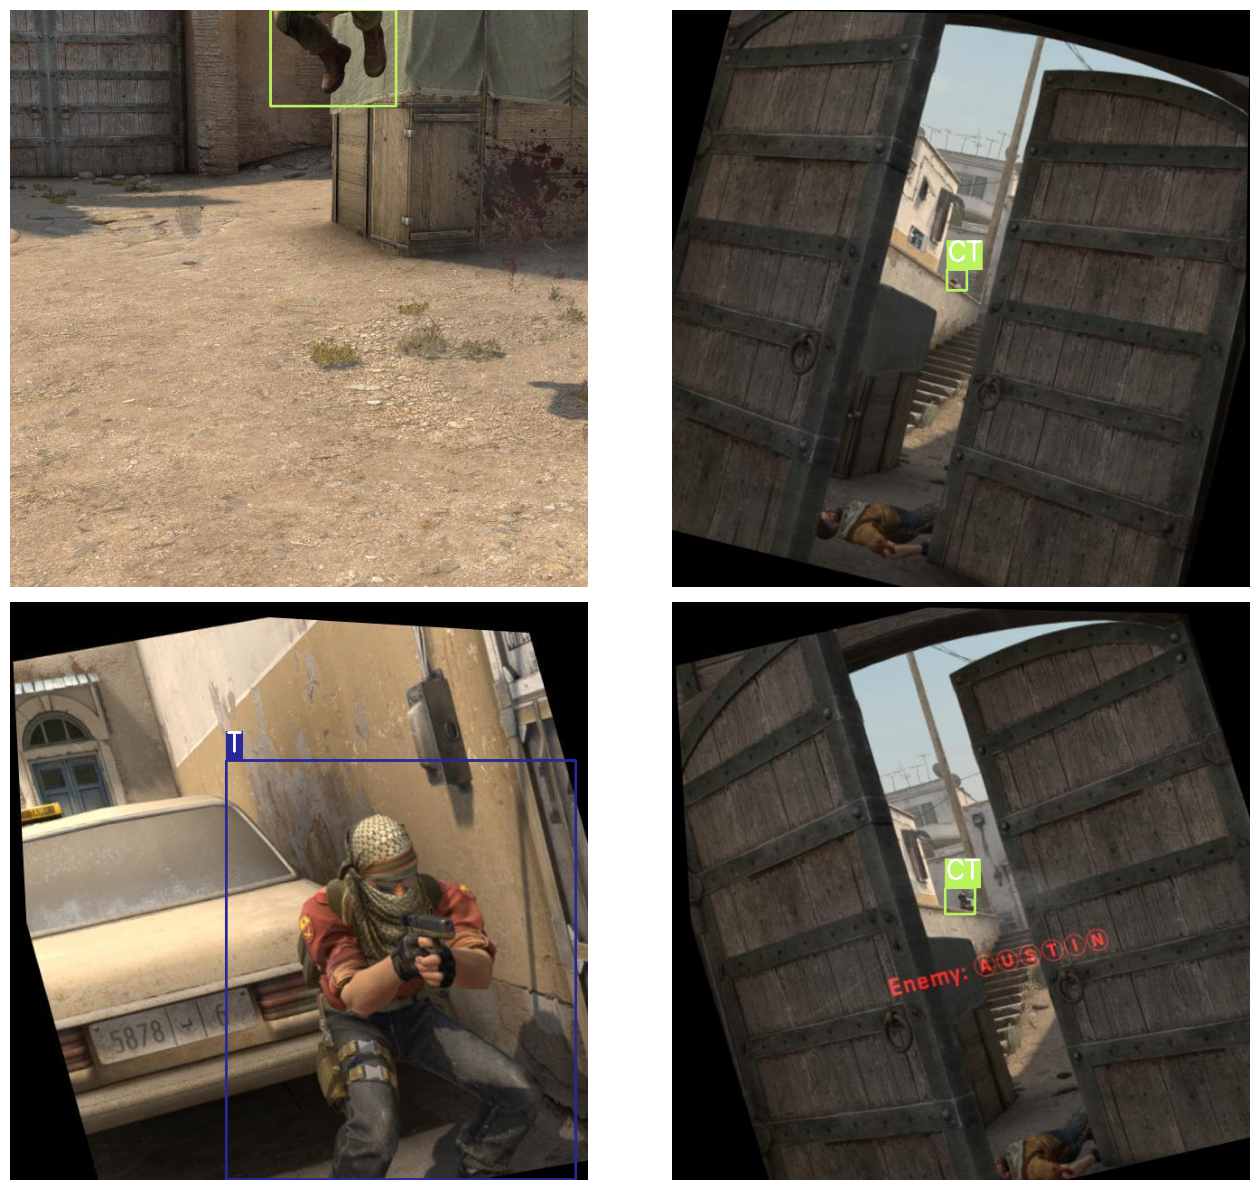

In [8]:
# Visualize a few training images.
plot(
    image_paths='valid/images/*', 
    label_paths='valid/labels/*',
    num_samples=4,
)

In [9]:
def set_res_dir():
    """
    function for setting results directory
    """
    
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [10]:
# Clone YOLOv5 from official repo
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15656, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 15656 (delta 137), reused 179 (delta 102), pack-reused 15393
Receiving objects: 100% (15656/15656), 14.66 MiB | 22.40 MiB/s, done.
Resolving deltas: 100% (10661/10661), done.


In [ ]:
# Change directory
%cd yolov5/
!pwd

In [ ]:
# Install all req for YOLOv5
!pip install -r requirements.txt

In [ ]:
# We will train for 30 epochs with standard hyperparameters (as the task is not really hard, it's expected to get good results even without hyperparameter optimization) 
# Note that best model will be saved automatically by ClearML, so no additional steps are required
TRAIN = True
EPOCHS = 30
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5s.pt \ # we will use YOLOv5 small version
    --img 640 \ # all images in dataset are 640x640 so we will keep the same size 
    --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} --bbox_interval 1 --save-period 1 